# Figure 6

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage

from gambit.seq import SequenceFile
from gambit.kmers import KmerSpec
from gambit.sigs.calc import calc_file_signatures
from gambit.metric import jaccarddist_pairwise
from gambit_pub.dendrograms import linkage_to_df, make_dendrogram, draw_dendrogram

In [2]:
%matplotlib inline

plt.rcdefaults()

## Code

## Setup

In [3]:
in_dir = Path('../../src-data/genome-sets/ecoli-genomes-fig6/')
out_dir = Path('../../results/figure-6/')
out_dir.mkdir(exist_ok=True)

In [4]:
genomes_df = pd.read_csv(in_dir / 'genomes.csv')
ngenomes = genomes_df.shape[0]

In [5]:
genome_paths = [in_dir / f'fasta/{id}.fasta' for id in genomes_df['id']]
genome_files = SequenceFile.from_paths(genome_paths, 'fasta')

## Calculate signatures

In [6]:
kspec = KmerSpec(11, 'ATGAC')

sigs = calc_file_signatures(kspec, genome_files, progress=True)

100%|██████████| 29/29 [00:09<00:00,  3.01it/s]


## Distance matrix

In [7]:
dmat = jaccarddist_pairwise(sigs)

In [8]:
dmat_df = pd.DataFrame(dmat, index=genomes_df['id'], columns=genomes_df['id'])
dmat_df.to_csv(out_dir / 'dmat.csv')

## Clustering

In [9]:
link = linkage(squareform(dmat), 'average')
nodes  = linkage_to_df(link)
nnodes = nodes.shape[0]

In [10]:
# Assign phylogroups
nodes.loc[:ngenomes, 'phylogroup'] = genomes_df['phylogroup']
for i in range(ngenomes, nnodes):
    left_pg = nodes.loc[nodes.loc[i, 'left'], 'phylogroup']
    right_pg = nodes.loc[nodes.loc[i, 'right'], 'phylogroup']
    if pd.notnull(left_pg) and left_pg == right_pg:
        nodes.loc[i, 'phylogroup'] = left_pg

## Plot

In [11]:
phylogroups = genomes_df['phylogroup'].unique()
phylogroups.sort()

phylo_palette = sns.color_palette('Set1', len(phylogroups))
# phylo_colors = {pg: rgb2hex(rgb) for pg, rgb in zip(phylogroups, phylo_palette)}
phylo_colors = dict(zip(phylogroups, phylo_palette))
genome_colors = [phylo_colors[pg] for pg in genomes_df['phylogroup']]

phylo_palette

[(0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 (0.30196078431372547, 0.6862745098039216, 0.2901960784313726),
 (0.596078431372549, 0.3058823529411765, 0.6392156862745098),
 (1.0, 0.4980392156862745, 0.0)]

Parameters for manual subplot positioning. Calculate without regard for padding between subplots and figure edge, will be taken care of automatically when saving the figure.

In [12]:
fig_h = 4

# Width of subplots and horizontal padding between them
ax_pad = [.15, .45, .2]
ax_width = [.5 * fig_h, .25, fig_h, .2]

# Left side of axes in physical coordinates (inches)
ax_left = []
for i in range(4):
    left = 0 if i == 0 else ax_left[i-1] + ax_width[i-1] + ax_pad[i-1]
    ax_left.append(left)

fig_w = sum(ax_pad) + sum(ax_width)

# Subplot rects as proportion of figure size (argument to Figure.add_axes())
ax_rects = [(l / fig_w, 0, w / fig_w, 1) for l, w in zip(ax_left, ax_width)]

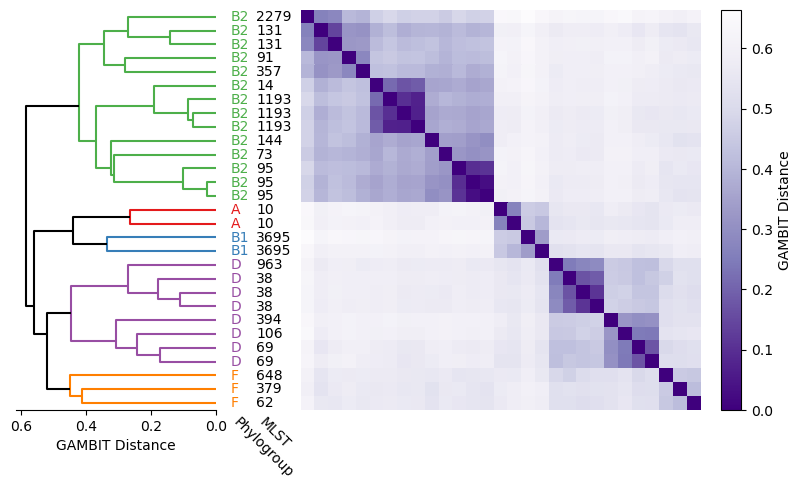

In [13]:
# Create figure and subplots
fig = plt.figure(
    figsize=(fig_w, fig_h),
)

dg_ax = fig.add_axes(ax_rects[0])
tbl_ax = fig.add_axes(ax_rects[1], sharey=dg_ax)
hm_ax = fig.add_axes(ax_rects[2], sharey=dg_ax)
cbar_ax = fig.add_axes(ax_rects[3])

# Dendrogram
dg = make_dendrogram(nodes, left=.5)
draw_dendrogram(
    dg_ax,
    dg,
    horizontal=True,
    colorfunc=lambda i: phylo_colors.get(nodes.loc[i, 'phylogroup'], 'black'),
)
dg_ax.invert_xaxis()
dg_ax.invert_yaxis()
dg_ax.set_xlim(None, 0)
dg_ax.set_xlabel('GAMBIT Distance')

for side in ['left', 'top', 'right']:
    dg_ax.spines[side].set_visible(False)

# Heatmap
lo = dg['leaf_order']
hm = hm_ax.pcolor(dmat[np.ix_(lo, lo)], cmap='Purples_r')
# sns.heatmap(dmat[np.ix_(lo, lo)], ax=hm_ax, cmap='Purples_r', cbar=False)

hm_ax.axis('off')
hm_ax.set_aspect(1, share=False, adjustable='box', anchor='W')
# hm_ax.axis('image')

# Table
# tbl_ax.axis('off')
for spine in tbl_ax.spines.values():
    spine.set_visible(False)

for i, gi in enumerate(lo):
    pg = genomes_df.loc[gi, 'phylogroup']
    tbl_ax.text(0, i + .5, pg, ha='left', va='center', color=phylo_colors[pg])
    tbl_ax.text(1, i + .5, genomes_df.loc[gi, 'mlst'], ha='left', va='center')

tbl_ax.set_xticks([0, 1], labels=['Phylogroup', 'MLST'], rotation=-45, ha='left', va='top')
tbl_ax.set_yticks([])
tbl_ax.tick_params(length=0)
tbl_ax.set_xlim(.0, 1.0)

# Color bar
plt.colorbar(
    hm,
    cax=cbar_ax,
    label='GAMBIT Distance',
)


In [14]:
fig.savefig(out_dir / 'figure-6.png', dpi=300, bbox_inches='tight')